In [ ]:
batch_size = 10
dataset_for_train = dataset.transform(myutils.transform_fn)
dataloader = mx.gluon.data.DataLoader(dataset_for_train, batch_size=batch_size, shuffle=True)
batchiter = iter(dataloader)
batch_img, batch_label = next(batchiter)
print(batch_img.shape)
print(batch_label.shape)

In [1]:
import mxnet as mx
import gluoncv as gcv
import numpy as np
import matplotlib.pyplot as plt
import myutils
import importlib
import yolo_utils

total num of data entries: 163


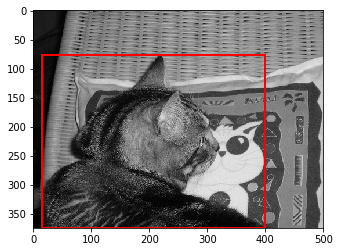

In [2]:
dataset = myutils.Dataset('cat_train.txt')
print('total num of data entries:', len(dataset))

img, label = dataset[3]
myutils.data_visualize(img=img, bboxes=label[:, 1:])

## 生成 yolo 的一个 target

最后生成的 shape 是$S \times S \times (B * 5 + C)$，令$S = 7$，$B = 2$，$C = 20$

`mx.nd.contrib.box_iou(boxes_1, boxes_2)`

`boxes_1`: mx.nd.array, float32, (N_1, 4)

`boxes_2`: mx.nd.array, float32, (N_2, 4)

`return`: iou, mx.nd.array, float32, (N_1, N_2) 

建议把 reference box 写在第二个位置，这样产生出来的 iou 的 shape 比较舒服。

# 生成一个 network

In [3]:
ctx = mx.cpu()

class YOLO_v1(mx.gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(YOLO_v1, self).__init__(**kwargs)
        
        resnet = mx.gluon.model_zoo.vision.get_resnet(2, 50, pretrained=True, ctx=ctx, 
                                                      root='D:\Documents\Data_Files\Parameters')
        with self.name_scope():
            self.expanded_feature_extractor = resnet.features[:11]  # (b, 2048, a, b)
            self.expanded_feature_extractor.add(mx.gluon.nn.Conv2D(1024, kernel_size=(1, 1), activation='relu'))
            self.expanded_feature_extractor.add(mx.gluon.nn.Conv2D(1024, kernel_size=(3, 3), activation='relu'))
            self.expanded_feature_extractor.add(mx.gluon.nn.Conv2D(1024, kernel_size=(3, 3), activation='relu'))
            self.expanded_feature_extractor.add(mx.gluon.nn.Conv2D(1024, kernel_size=(3, 3), activation='relu'))
            self.expanded_feature_extractor.add(mx.gluon.nn.Dense(4096, activation='relu'))
            self.expanded_feature_extractor.add(mx.gluon.nn.Dense(7 * 7 * 30))
            self.expanded_feature_extractor.add(mx.gluon.nn.activations.LeakyReLU(0.1))
            
        self.expanded_feature_extractor[-7:].collect_params().initialize(init=mx.init.Xavier())
        return
    
    def forward(self, x):
        out = self.expanded_feature_extractor(x)
        out = out.reshape((-1, 7, 7, 30))
        return out

yolo = YOLO_v1()
yolo.hybridize()
out = yolo(mx.nd.empty((1, 3, 448, 448)))
out.shape

(1, 7, 7, 30)

In [4]:
trainer = mx.gluon.Trainer(yolo.collect_params(), 'sgd')
trainer.set_learning_rate(0.1)

epoch 0
tensor predicted:
[-2.6814789e-02  2.7396214e-01  3.1567225e-01  4.4275269e-02
  5.7464734e-02  2.0280106e-01  3.0526489e-02  1.9873060e-02
 -9.7355014e-03  4.9607463e-02  9.4469011e-02 -2.2651181e-04
  4.2704456e-03  8.9661941e-02  2.0442906e-01  4.4420496e-02
 -5.2960690e-02 -2.8847361e-02  1.4197746e-01 -6.9996291e-03
  3.4675729e-01 -5.9900910e-02  4.5161644e-01 -4.3839347e-02
 -1.1234129e-02  7.6602533e-02 -3.9464481e-02 -2.2549951e-02
 -2.0269817e-02  4.2517382e-01]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


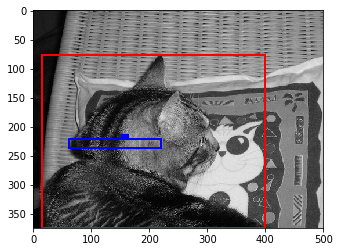

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 1
tensor predicted:
[ 9.2481486e-02 -6.4628809e-03  2.8191668e-01  1.6218241e+00
  1.8850707e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8893803e-03  2.0004531e-02
 -8.5408908e-05 -1.7932389e-03 -4.0885815e-03 -8.8840997e-04
  1.0592139e-03  5.7694723e-04 -2.8395492e-03  1.3999258e-04
 -6.9351457e-03  1.1980183e-03 -9.0323295e-03  8.7678694e-04
  2.2468258e-04 -1.5320507e-03  7.8928965e-04  4.5099907e-04
  4.0539633e-04 -8.5034771e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


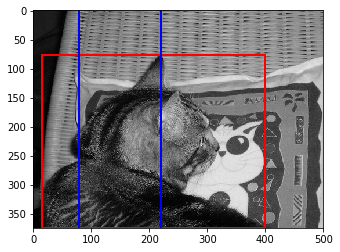

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 2
tensor predicted:
[ 8.98000062e-01 -4.30491893e-03  6.09321952e-01  1.47240496e+00
  3.50805640e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.88560155e-03  2.16003627e-01
 -8.52380981e-05 -1.78965239e-03 -4.08040453e-03 -8.86633177e-04
  8.47371120e-04  4.61557793e-04 -2.83387024e-03  1.11994064e-04
 -6.92127598e-03  9.58414632e-04 -9.01426468e-03  7.01429555e-04
  1.79746057e-04 -1.52898661e-03  6.31431700e-04  3.60799255e-04
  3.24317080e-04 -8.48647021e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


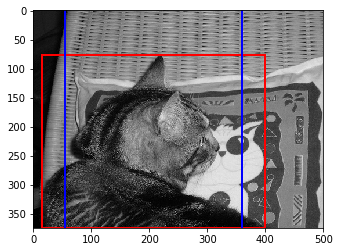

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 3
tensor predicted:
[ 8.9800000e-01 -2.1685360e-03  6.7212343e-01  1.3403444e+00
  4.8064452e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8818304e-03  3.7280291e-01
 -8.5067615e-05 -1.7860731e-03 -4.0722433e-03 -8.8485994e-04
  6.7789690e-04  3.6924623e-04 -2.8282027e-03  8.9595254e-05
 -6.9074333e-03  7.6673168e-04 -8.9962361e-03  5.6114362e-04
  1.4379685e-04 -1.5259286e-03  5.0514535e-04  2.8863939e-04
  2.5945366e-04 -8.4694969e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


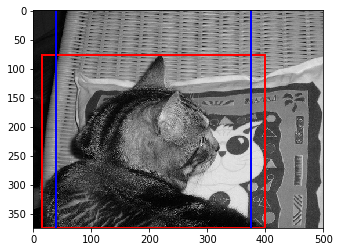

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 4
tensor predicted:
[ 8.98000002e-01 -5.35173349e-05  7.07986832e-01  1.22598410e+00
  5.84515631e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.87806680e-03  4.98242319e-01
 -8.48974814e-05 -1.78250100e-03 -4.06409893e-03 -8.83090252e-04
  5.42317517e-04  2.95396982e-04 -2.82254606e-03  7.16762006e-05
 -6.89361850e-03  6.13385346e-04 -8.97824392e-03  4.48914885e-04
  1.15037474e-04 -1.52287667e-03  4.04116290e-04  2.30911508e-04
  2.07562931e-04 -8.45255796e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


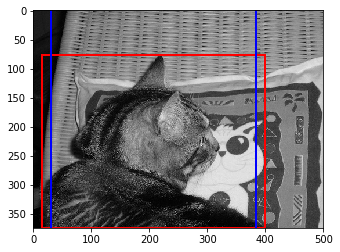

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 5
tensor predicted:
[ 8.9800000e-01  2.0403512e-02  7.3010170e-01  1.1292092e+00
  6.6761249e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8743105e-03  5.9859383e-01
 -8.4727682e-05 -1.7789360e-03 -4.0559708e-03 -8.8132406e-04
  4.3385400e-04  2.3631759e-04 -2.8169011e-03  5.7340960e-05
 -6.8798312e-03  4.9070828e-04 -8.9602871e-03  3.5913190e-04
  9.2029979e-05 -1.5198309e-03  3.2329303e-04  1.8472920e-04
  1.6605035e-04 -8.4356526e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


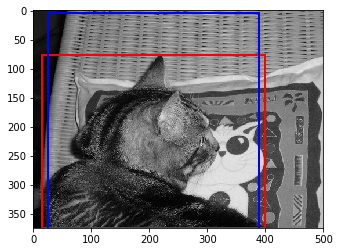

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 6
tensor predicted:
[ 8.9800000e-01  2.0933333e-01  7.4424833e-01  1.0493577e+00
  7.3408997e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8705620e-03  6.7887509e-01
 -8.4558233e-05 -1.7753782e-03 -4.0478590e-03 -8.7956147e-04
  3.4708320e-04  1.8905407e-04 -2.8112673e-03  4.5872766e-05
 -6.8660714e-03  3.9256661e-04 -8.9423666e-03  2.8730551e-04
  7.3623982e-05 -1.5167913e-03  2.5863442e-04  1.4778336e-04
  1.3284027e-04 -8.4187817e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


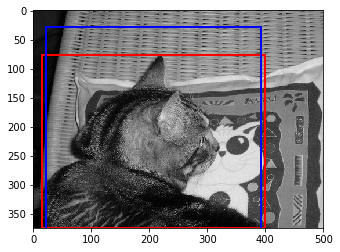

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 7
tensor predicted:
[ 8.98000002e-01  2.09333330e-01  7.53485084e-01  9.85198796e-01
  7.87271976e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.86682085e-03  7.43100047e-01
 -8.43891103e-05 -1.77182746e-03 -4.03976301e-03 -8.77802377e-04
  2.77666550e-04  1.51243265e-04 -2.80564465e-03  3.66982131e-05
 -6.85233949e-03  3.14053294e-04 -8.92448239e-03  2.29844401e-04
  5.88991861e-05 -1.51375763e-03  2.06907542e-04  1.18226686e-04
  1.06272215e-04 -8.40194430e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


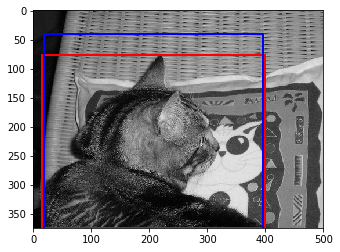

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 8
tensor predicted:
[ 8.9800000e-01  2.0933333e-01  7.5959086e-01  9.3500769e-01
  8.2981759e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8630872e-03  7.9448003e-01
 -8.4220337e-05 -1.7682838e-03 -4.0316838e-03 -8.7604672e-04
  2.2213324e-04  1.2099461e-04 -2.8000334e-03  2.9358571e-05
 -6.8386346e-03  2.5124263e-04 -8.9066336e-03  1.8387553e-04
  4.7119349e-05 -1.5107301e-03  1.6552603e-04  9.4581352e-05
  8.5017775e-05 -8.3851395e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


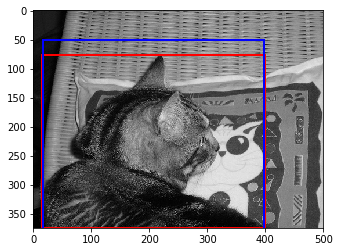

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 9
tensor predicted:
[ 8.9800000e-01  2.0933333e-01  7.6365846e-01  8.9673162e-01
  8.6385405e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8593610e-03  8.3558404e-01
 -8.4051891e-05 -1.7647472e-03 -4.0236204e-03 -8.7429461e-04
  1.7770659e-04  9.6795688e-05 -2.7944334e-03  2.3486857e-05
 -6.8249577e-03  2.0099411e-04 -8.8888202e-03  1.4710042e-04
  3.7695478e-05 -1.5077087e-03  1.3242083e-04  7.5665084e-05
  6.8014218e-05 -8.3683692e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


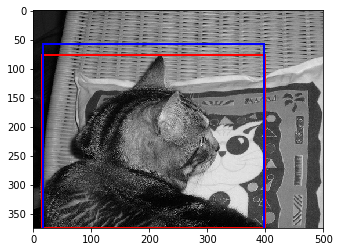

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 10
tensor predicted:
[ 8.98000002e-01  2.09333330e-01  7.66381800e-01  8.68206680e-01
  8.91083241e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.85564219e-03  8.68467212e-01
 -8.38837877e-05 -1.76121760e-03 -4.01557283e-03 -8.72546050e-04
  1.42165271e-04  7.74365471e-05 -2.78884452e-03  1.87894857e-05
 -6.81130728e-03  1.60795287e-04 -8.87104217e-03  1.17680334e-04
  3.01563814e-05 -1.50469318e-03  1.05936662e-04  6.05320674e-05
  5.44113755e-05 -8.35163239e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


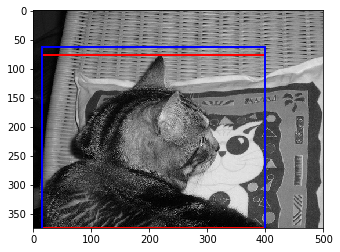

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 11
tensor predicted:
[ 8.9800000e-01  2.0933333e-01  7.6821113e-01  8.4736431e-01
  9.1286659e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8519309e-03  8.9477378e-01
 -8.3716026e-05 -1.7576952e-03 -4.0075420e-03 -8.7080098e-04
  1.1373222e-04  6.1949235e-05 -2.7832668e-03  1.5031588e-05
 -6.7976848e-03  1.2863622e-04 -8.8533005e-03  9.4144270e-05
  2.4125105e-05 -1.5016838e-03  8.4749328e-05  4.8425652e-05
  4.3529100e-05 -8.3349291e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


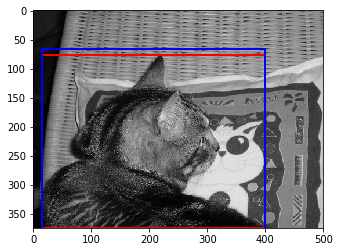

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 12
tensor predicted:
[ 8.98000002e-01  2.09333330e-01  7.68334270e-01  8.45865786e-01
  9.14609253e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.85156055e-03  8.96878302e-01
 -8.36992840e-05 -1.75734365e-03 -4.00674017e-03 -8.70626827e-04
  1.11457572e-04  6.07102484e-05 -2.78271013e-03  1.47309565e-05
 -6.79632509e-03  1.26063504e-04 -8.85152910e-03  9.22613835e-05
  2.36426040e-05 -1.50138349e-03  8.30543431e-05  4.74571389e-05
  4.26585175e-05 -8.33326206e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


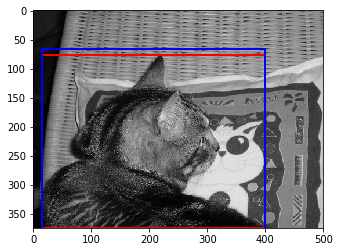

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 13
tensor predicted:
[ 8.9800000e-01  2.0933333e-01  7.6845342e-01  8.4441018e-01
  9.1631705e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8511902e-03  8.9894074e-01
 -8.3682542e-05 -1.7569922e-03 -4.0059388e-03 -8.7045267e-04
  1.0922842e-04  5.9496044e-05 -2.7821537e-03  1.4436338e-05
 -6.7949663e-03  1.2354224e-04 -8.8497587e-03  9.0416157e-05
  2.3169752e-05 -1.5010833e-03  8.1393257e-05  4.6507997e-05
  4.1805346e-05 -8.3315959e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


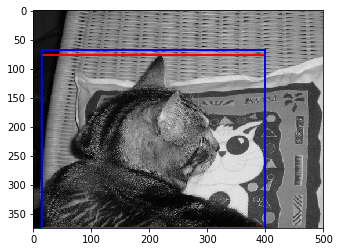

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 14
tensor predicted:
[ 8.98000002e-01  2.09333330e-01  7.68568695e-01  8.42996418e-01
  9.17990685e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.85082003e-03  9.00961936e-01
 -8.36658073e-05 -1.75664073e-03 -4.00513737e-03 -8.70278571e-04
  1.07043852e-04  5.83061228e-05 -2.78159720e-03  1.41476112e-05
 -6.79360703e-03  1.21071396e-04 -8.84798821e-03  8.86078342e-05
  2.27063574e-05 -1.50078291e-03  7.97653920e-05  4.55778390e-05
  4.09692402e-05 -8.32992978e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


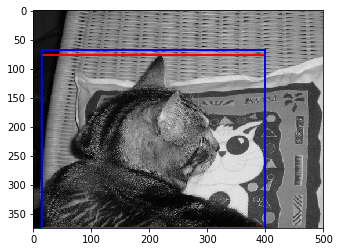

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 15
tensor predicted:
[ 8.98000002e-01  2.09333330e-01  7.68680155e-01  8.41623366e-01
  9.19630885e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.85044983e-03  9.02942717e-01
 -8.36490726e-05 -1.75628939e-03 -4.00433643e-03 -8.70104530e-04
  1.04902974e-04  5.71400014e-05 -2.78104073e-03  1.38646592e-05
 -6.79224823e-03  1.18649972e-04 -8.84621870e-03  8.68356801e-05
  2.22522303e-05 -1.50048279e-03  7.81700874e-05  4.46662816e-05
  4.01498546e-05 -8.32826365e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


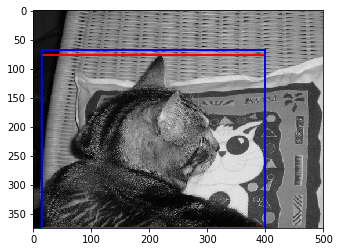

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 16
tensor predicted:
[ 8.98000002e-01  2.09333330e-01  7.68787980e-01  8.40289950e-01
  9.21238244e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.85007975e-03  9.04883862e-01
 -8.36323452e-05 -1.75593817e-03 -4.00353549e-03 -8.69930431e-04
  1.02804916e-04  5.59972032e-05 -2.78048473e-03  1.35873661e-05
 -6.79088989e-03  1.16276969e-04 -8.84444918e-03  8.50989672e-05
  2.18071855e-05 -1.50018267e-03  7.66066878e-05  4.37729577e-05
  3.93468581e-05 -8.32659751e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


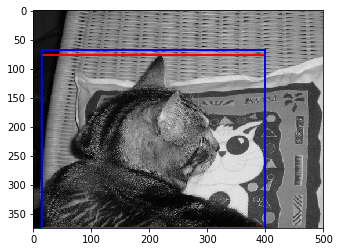

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 17
tensor predicted:
[ 8.9800000e-01  2.0933333e-01  7.6889235e-01  8.3899516e-01
  9.2281348e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8497097e-03  9.0678620e-01
 -8.3615618e-05 -1.7555871e-03 -4.0027350e-03 -8.6975651e-04
  1.0074882e-04  5.4877259e-05 -2.7799285e-03  1.3315619e-05
 -6.7895316e-03  1.1395143e-04 -8.8426806e-03  8.3396990e-05
  2.1371041e-05 -1.4998827e-03  7.5074553e-05  4.2897500e-05
  3.8559920e-05 -8.3249323e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


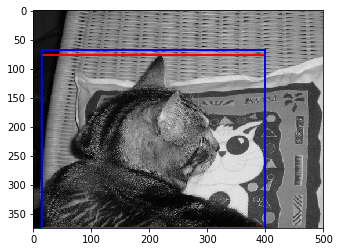

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 18
tensor predicted:
[ 8.9800000e-01  2.0933333e-01  7.6899326e-01  8.3773792e-01
  9.2435718e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8493397e-03  9.0865046e-01
 -8.3598890e-05 -1.7552359e-03 -4.0019345e-03 -8.6958252e-04
  9.8733843e-05  5.3779713e-05 -2.7793725e-03  1.3049306e-05
 -6.7881732e-03  1.1167240e-04 -8.8409120e-03  8.1729049e-05
  2.0943620e-05 -1.4995827e-03  7.3573065e-05  4.2039552e-05
  3.7788723e-05 -8.3232671e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


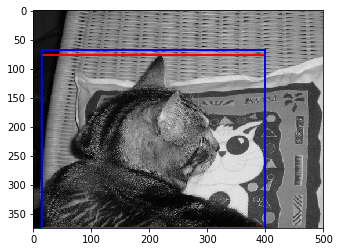

loss: 
[nan]
<NDArray 1 @cpu(0)>
epoch 19
tensor predicted:
[ 8.9800000e-01  2.0933333e-01  7.6909089e-01  8.3651727e-01
  9.2587006e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.8489698e-03  9.1047746e-01
 -8.3582177e-05 -1.7548848e-03 -4.0011341e-03 -8.6940866e-04
  9.6759162e-05  5.2704119e-05 -2.7788167e-03  1.2788320e-05
 -6.7868158e-03  1.0943895e-04 -8.8391444e-03  8.0094469e-05
  2.0524747e-05 -1.4992828e-03  7.2101604e-05  4.1198760e-05
  3.7032947e-05 -8.3216028e-03]
tensor target:
[0.898      0.20933333 0.772      0.79733333 1.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


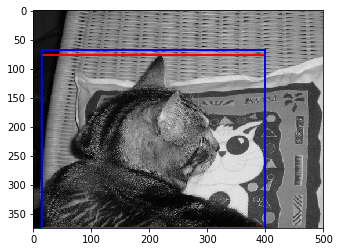

loss: 
[nan]
<NDArray 1 @cpu(0)>


In [5]:
for epoch in range(20):
    print('epoch', epoch)
    with mx.autograd.record():
        trsfm_img = yolo_utils.transform_image(img)
        out = yolo(trsfm_img)
        target = yolo_utils.generate_target(img, label, out[0].asnumpy())
        loss = yolo_utils.calc_yolo_loss(out.reshape(7, 7, 30), target)
    loss.backward()
    trainer.step(1)
    if epoch == 10:
        trainer.set_learning_rate(0.01)

## non-maximum suppression algorithm

这个算法的主要思想是删去那些重合度很高的 bounding boxes，但是并**不做融合**。

steps:

1. 对 boxes 按 score 进行降序排列，挑出 score 最大的那个 box。假设我们把它称为 box_1
2. 分别计算 box_1 和其它 boxes 的 IOU，如果 IOU 值小于 threshold，则保留，否则将其它的那个 box 删除。
3. 现在与 box_1 相关的框已经筛选完毕了，接下来把 box_1 排除在外，挑选剩下的框中，score 最高的那个，并重复步骤2
4. 按照上述方法，不断重复步骤2和3，直到把所有的 boxes 都处理完。

此时所有的 boxes 只有两个去向：要么被保留，要么被删除。被保留下来的，基本上都是离得比较远或 IOU 比较小的 boxes。

nms 效果示例：

```python
import mxnet as mx
import matplotlib.pyplot as plt
import myutils

s = (10, 6)
boxes_with_score = mx.nd.empty(shape=s)
boxes_with_score[:, 2:4] = mx.nd.array([[0.25, 0.25]] * s[0])
boxes_with_score[:, 4:6] = mx.nd.random_normal(loc=0.7, scale=0.2, shape=(s[0], 2))
boxes_with_score[:, 0] = 0
img = mx.nd.uniform(0, 1, shape=(300, 300))
fig = plt.imshow(img.asnumpy())
axes = fig.axes
for box in boxes_with_score:
    myutils._add_rectangle(axes, box[2:].asnumpy())
plt.show()
print('number of raw boxes:', len(boxes_with_score))

output = mx.nd.contrib.box_nms(data=boxes_with_score)

fig = plt.imshow(img.asnumpy())
axes = fig.axes
count_boxes = 0
for box in output:
    if abs(box[0].asscalar() + 1) > 1e-3:
        count_boxes += 1
        myutils._add_rectangle(axes, box[2:].asnumpy(), color='blue')
plt.show()
print('number of boxes filtered:', count_boxes)
```

更详细的资料可以参考[这篇文章](https://medium.com/@chih.sheng.huang821/機器-深度學習-物件偵測-non-maximum-suppression-nms-aa70c45adffa)